Here are some tests and copied code from main.py file

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import networkx as nx
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# quite important - scipy version at least 1.8 is required


class Graph:
    def __init__(self):
        self.G = nx.graph
        self.L = None  # Laplacian of a graph
        self.A = None  # Adjacency matrix of a graph G
        self.D = None  # Degree matrix of a graph G
        self.n = 0  # number of nodes in matrix - parameter to avoid unnecessary computation

    # functions to create various graphs
    def ba_graph(self, init_nodes, final_nodes, m):
        """
        function creates Barabsi-Albert graph
        :param init_nodes:
        :param final_nodes:
        :param m:
        :return:
        """
        def choose_node(new_node):
            """
            :returns to which node connect the new_node
            """
            nodes_probability = []
            num_edges = self.G.number_of_edges()
            new_node_deg = self.G.degree(new_node)

            for node in self.G.nodes():
                if node == new_node:
                    nodes_probability.append(0)
                else:
                    node_deg = self.G.degree(node)
                    node_prob = node_deg / ((2 * num_edges) - new_node_deg)
                    nodes_probability.append(node_prob)

            return np.random.choice(self.G.nodes(), p=nodes_probability)

        def add_edge(new_node):
            """
            function randomly adds new edge to previously created node - new_node
            :param new_node:
            :return:
            """
            if len(self.G.edges()) == 0:
                random_node = 0
            else:
                random_node = choose_node(new_node)
            new_edge = (new_node, random_node)
            if new_edge in self.G.edges() or random_node == new_node:
                add_edge(new_node)  # if an edge exist or isn't valid - repeat the process
            
            self.G.add_edge(new_node, random_node)

        assert final_nodes >= init_nodes >= m

        self.G = nx.complete_graph(init_nodes)

        for i in range(final_nodes - init_nodes):
            self.G.add_node(init_nodes + i)
            for e in range(0, m):
                add_edge(init_nodes + i)

        print(f"Created a ba graph, with {final_nodes} nodes")

    def cycle_graph(self, n):
        print(f"Created a cycle graph, with {n} nodes")
        self.G = nx.cycle_graph(n)

    def complete_graph(self, n):
        print(f"Created a complete graph, with {n} nodes")
        self.G = nx.complete_graph(n)

    def barbell_graph(self, m, n):
        print(f"Created a barbell graph, with {m} and {n} nodes")
        self.G = nx.barbell_graph(m, n)

    # functions to show results
    def visualize(self, title="graph visualisation"):
        """ function plots graph G using matplotlib and networkx"""
        plt.title(title)
        nx.draw_networkx(self.G)
        plt.show()

    def visualize_matrix(self, Y, title="graph projected to 2-dim space"):
        """ function simply draws a plot with matplotlib """
        Y = np.reshape(Y, (2, -1))
        plt.title(title)
        plt.scatter(Y[0], Y[1])
        plt.show()

    def update(self):
        """
        function updates all necesary matrices for computations
        :return:
        """
        def adjacency_matrix():
            return nx.to_scipy_sparse_array(self.G).toarray()

        def degree_matrix():
            return self.L + self.A

        def laplacian_matrix():
            return nx.laplacian_matrix(self.G).toarray()

        self.L = laplacian_matrix()
        self.A = adjacency_matrix()
        self.D = degree_matrix()
        self.n = self.G.number_of_nodes()

    # functions to solve problems
    def find_opt_y_eig(self, d):
        """
        function finds matrices Y, such that Y^T @ D @ Y = I and tr(Y^T @ L @ Y) is the smallest

        as we know from the sources, such matrix Y could be obtained from evaluating and processing d smallest non-zero
        eigenvalues

        the function is here mainly for comparing the results

        :param d: number of dimensions to project the graph G
        :return: matrix Y - representation of graph in d dimensions

        example:
        cycle of 3 nodes is well represented by matrix
        Y = {{-1, 0, 1}, {-1, 1, 0}}
        """

        # we assume that, there are no nodes of degree 0 - matrix D should be invertible
        eig = np.linalg.eigh(np.matmul(np.linalg.inv(self.D), self.L))
        w, v = eig  # eigenvalues and eigenvectors

        # processing eigenvalues and vectors to sort them later
        eig = [(w[i], np.asarray(v[i])) for i in range(len(w))]
        eig.sort(key=lambda tup: tup[0])

        e = [eig[i][1] for i in range(1, d + 1)] # d eigenvectors corresponding to smallest non-zero eigenvalues
        # v = [eig[i][0] for i in range(1, d + 1)]

        res = np.array(e)

        return res.reshape(d, -1)

    def find_opt_y(self, d, ftol=1e-6):
        """
        function find_optimal_y has two parameters
        :param ftol: optional parameter - provides precision
        :param d - a non zero number that determines on how many dimensional space we will project the graph
        another parameter is the graph G

        :return function returns matrix Y of shape (d, n), where n is number of nodes in graph G. Matrix Y should
        represent graph G in d dimensions

        function uses scipy.optimize.minimize to evaluate its results

        example:
        cycle of 3 nodes is well represented by matrix
        Y = {{-1, 0, 1}, {-1, 1, 0}}
        """
        self.update()

        # functions to provide good results
        def cond(Y):
            """
            function checks if matrix Y provides condition that Y^T @ D @ Y = I
            where Y^T is the transposition of matrix Y, @ is the product of matrices, D is the degree matrix of graph G
            and I is the identity matrix

            funkcja returns 0 if the condistion is met, otherwise it returns absolute deviation of matrix difference:
            Y^T @ D @ Y - I
            """
            Y = np.reshape(Y, (self.n, d))  # thanks to this reshaping, Y can be one dimentional as opt.minimmize wishes
            A = np.matmul(np.matmul(np.transpose(Y), self.D), Y)
            B = np.identity(d)  # identity matrix of size A
            if np.allclose(A, B):
                return 0
            return np.mean(np.abs(A - B))

        def y_trace(Y):
            """
            function that should be minimalized
            our goal is to find matrix Y meeting condition cond, such that trace of product Y^T @ L @ Y shall be
            the smallest (where L is the laplacian of graph G
            :return trace of Y^T @ L @ Y
            """
            Y = np.reshape(Y, (self.n, d))  # thanks to this reshaping, Y can be one dimentional as opt.minimmize wishes
            return np.trace(np.matmul(np.matmul(np.transpose(Y), self.L), Y))

        Y = np.random.rand(self.n * d)
        # print(self.cond(Y))
        # print(self.y_trace(Y))
        cons = [{'type': 'eq', 'fun': cond}]

        res = opt.minimize(y_trace, Y, method="SLSQP", constraints=cons,  options={"ftol": ftol, "maxiter": 5000, "disp": False})

        #print(res)

        Y = np.reshape(res.x, (d, -1))

        #print(y_trace(Y))
        #print(cond(Y))  # checking the conditions - for tests only

        return Y

    def sklearn_embeding(self, d):
        """
        sklearn package that does what we do (almost)
        not sure if it works
        :return
        """
        embedding = SpectralEmbedding(n_components=2)
        return embedding.fit_transform(self.A).reshape(d, -1)

    @staticmethod
    def project_to_2_dimensions_with_pca(Y):
        x = StandardScaler().fit_transform(Y)
        print(np.mean(x), np.std(x))

        pca = PCA(n_components=2)
        reduced_x = pca.fit_transform(x.transpose())
        reduced_x = reduced_x.transpose()
        return reduced_x

    def show_results(self, graph_name, d=2):
        """
        function simply runs some tests
        """
        self.update()
        # visualisation of a graph
        self.visualize(f"{graph_name} of size {self.n}")

        scipy_res = self.find_opt_y(d)
        if d > 2:
            self.visualize_matrix(self.project_to_2_dimensions_with_pca(scipy_res),
                               f"scipy optimalization, {graph_name} of size {self.n}, projected to {d} dimensions")
        else:
            self.visualize_matrix(scipy_res, f"scipy optimalization, {graph_name} of size {self.n}")

        eig_res = self.find_opt_y_eig(d)
        if d > 2:
            self.visualize_matrix(self.project_to_2_dimensions_with_pca(eig_res),
                               f"optimalization with eigenvalues {graph_name} of size {self.n}, projected to {d} dimensions")
        else:
            self.visualize_matrix(eig_res, f"optimalization with eigenvalues, {graph_name} of size {self.n}")

In [24]:
np.random.seed(44)

Created a cycle graph, with 3 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


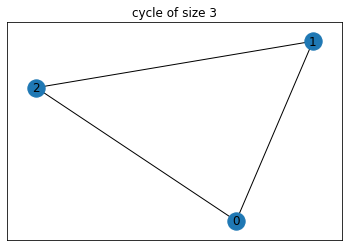

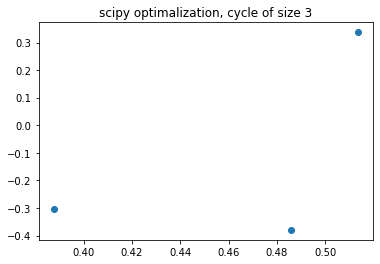

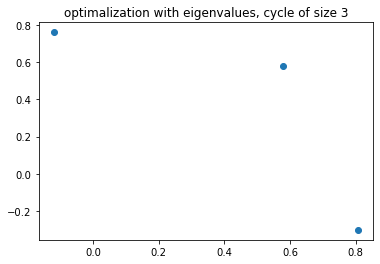

In [25]:
# examples
# two dimensional projection

n = 3
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle")

Created a cycle graph, with 10 nodes


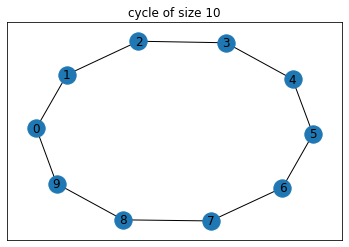

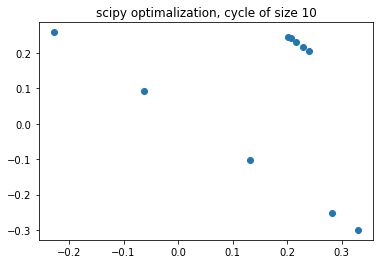

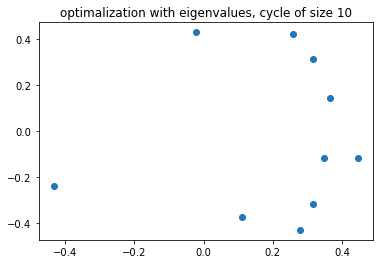

In [26]:
n = 10
graph.cycle_graph(n)
graph.show_results("cycle")

Created a barbell graph, with 5 and 3 nodes


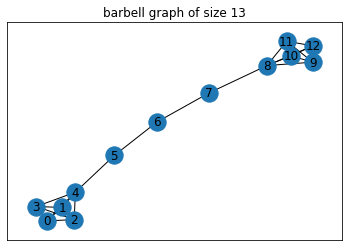

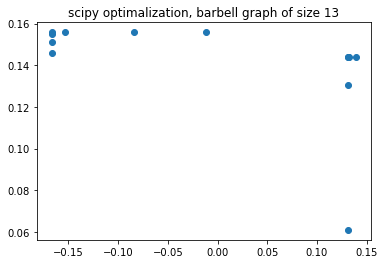

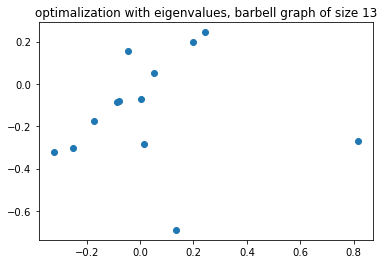

In [27]:
graph.barbell_graph(5, 3)
graph.show_results("barbell graph")

Created a ba graph, with 10 nodes


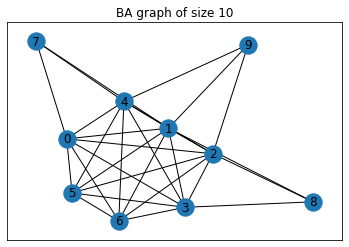

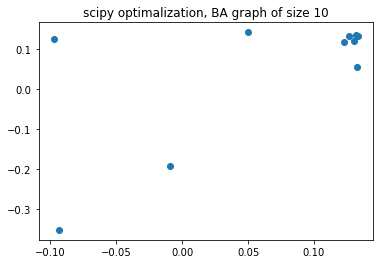

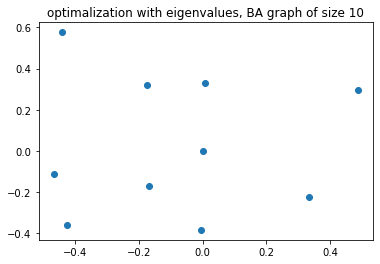

In [28]:
graph.ba_graph(7, 10, 3)
graph.show_results("BA graph")

Created a cycle graph, with 5 nodes


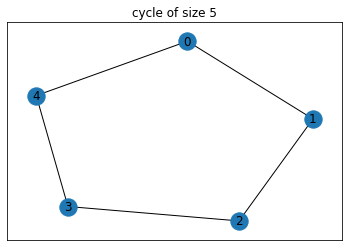

0.0 1.0


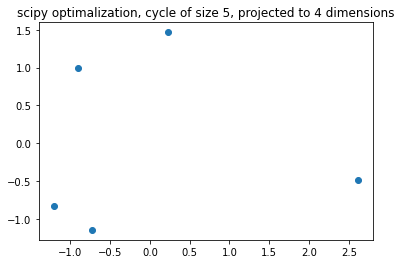

0.03779644730092273 0.9992854590012948


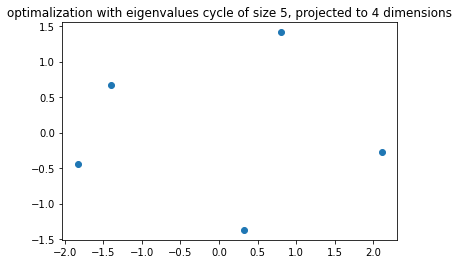

In [29]:
# multidimensional
n = 5
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle", 4)

Created a cycle graph, with 10 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


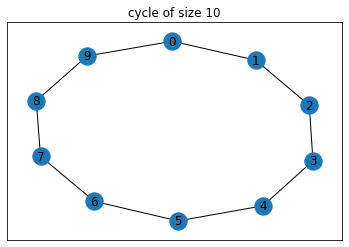

-3.552713678800501e-17 1.0


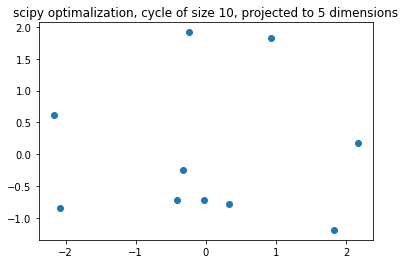

-2.886579864025407e-17 1.0


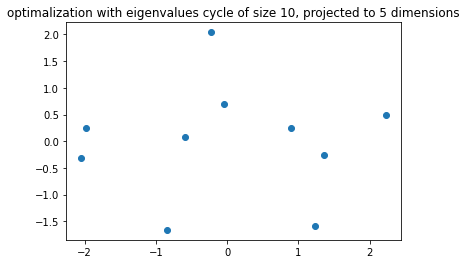

In [30]:
n = 10
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle", 5)

Created a cycle graph, with 10 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


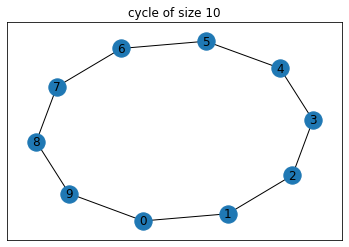

In [31]:
n = 10
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle", 8)

In [ ]:
graph.barbell_graph(5, 3)
graph.show_results("barbell_graph", 5)

In [ ]:
graph.ba_graph(7, 10, 3)
graph.show_results("BA graph", 6)